In [1]:
import os
import tempfile
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
MODEL_NAME = "xception65_cityscapes_trainfine" #@param ["mobilenetv3_large_cityscapes_trainfine", "xception65_cityscapes_trainfine"]

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv3_large_cityscapes_trainfine':
        'deeplab_mnv3_large_cityscapes_trainfine_2019_11_15.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}

MODEL_TAR = MODEL_URLS[MODEL_NAME]
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

# Download
!wget -O {MODEL_TAR} {MODEL_URL}

# Extract
MODEL_FILE = !tar -zxvf {MODEL_TAR} --wildcards --no-anchored 'frozen_inference_graph.pb'
MODEL_FILE = MODEL_FILE[0].strip()
print('Frozen graph file path:', MODEL_FILE)

--2024-10-10 08:08:16--  http://download.tensorflow.org/models/deeplabv3_cityscapes_train_2018_02_06.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.202.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460310119 (439M) [application/x-tar]
Saving to: ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’

deeplabv3_cityscape 100%[===================>] 438.99M  78.6MB/s    in 3.9s    

2024-10-10 08:08:20 (111 MB/s) - ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’ saved [460310119/460310119]

Frozen graph file path: deeplabv3_cityscapes_train/frozen_inference_graph.pb


In [3]:
# Load the TensorFlow model
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph
# because some operations (ArgMax) might not support the delegates.
# Insepct the graph using Netron https://lutzroeder.github.io/netron/
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE,
    input_arrays = ['sub_7'], # For the Xception model it needs to be `sub_7`, for MobileNet it would be `sub_2`
    output_arrays = ['ResizeBilinear_2']
)

# Optional: Perform the simplest optimization known as post-training dynamic range quantization.
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
# You can refer to the same document for other types of optimizations.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

_, tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  165712950 bytes
TFLite Model is      42565736 bytes
Post training dynamic range quantization saves 123147214 bytes


In [4]:
!ls -lh {tflite_path}

-rw------- 1 root root 41M Oct 10 08:09 /tmp/tmpub_oe0d0.tflite


In [5]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Get image size - converting from BHWC to WH # ([1,1025,2049,19]: Shape of ResizeBilinear_2 op)
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(2049, 1025)


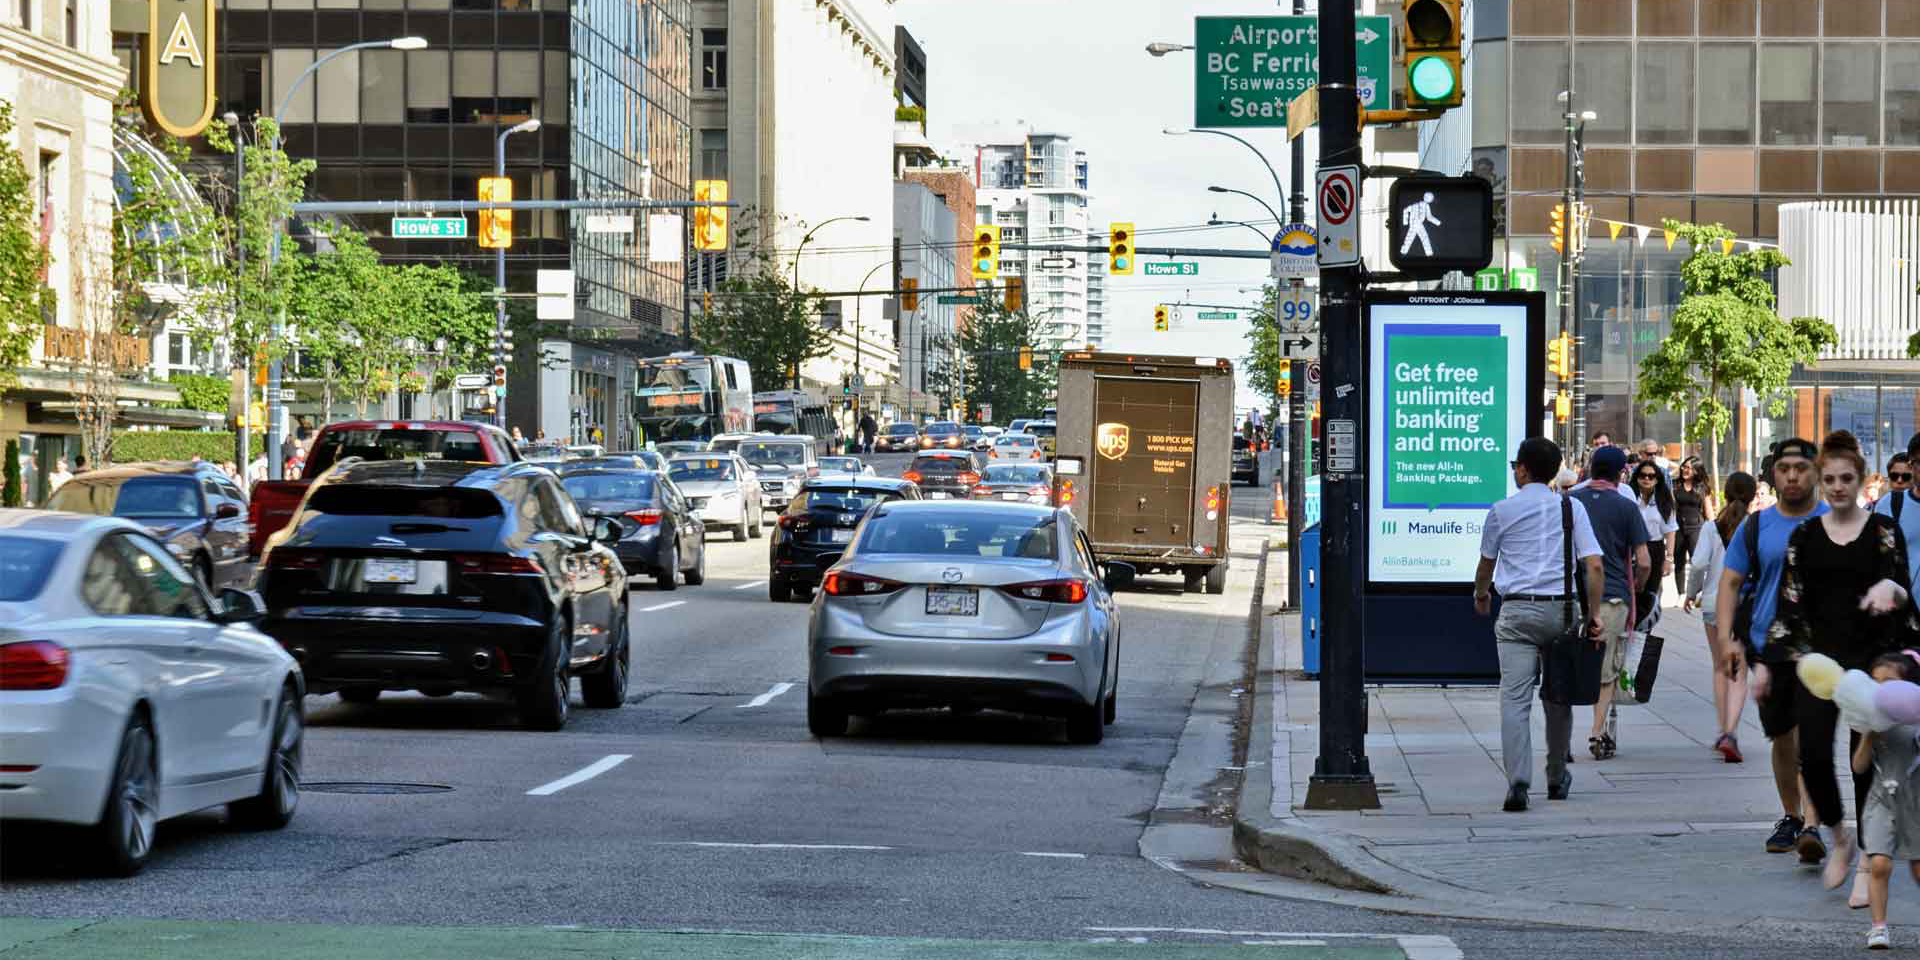

In [9]:
from PIL import Image
image = Image.open('city.png')
image

(1919, 960) (1920, 960)


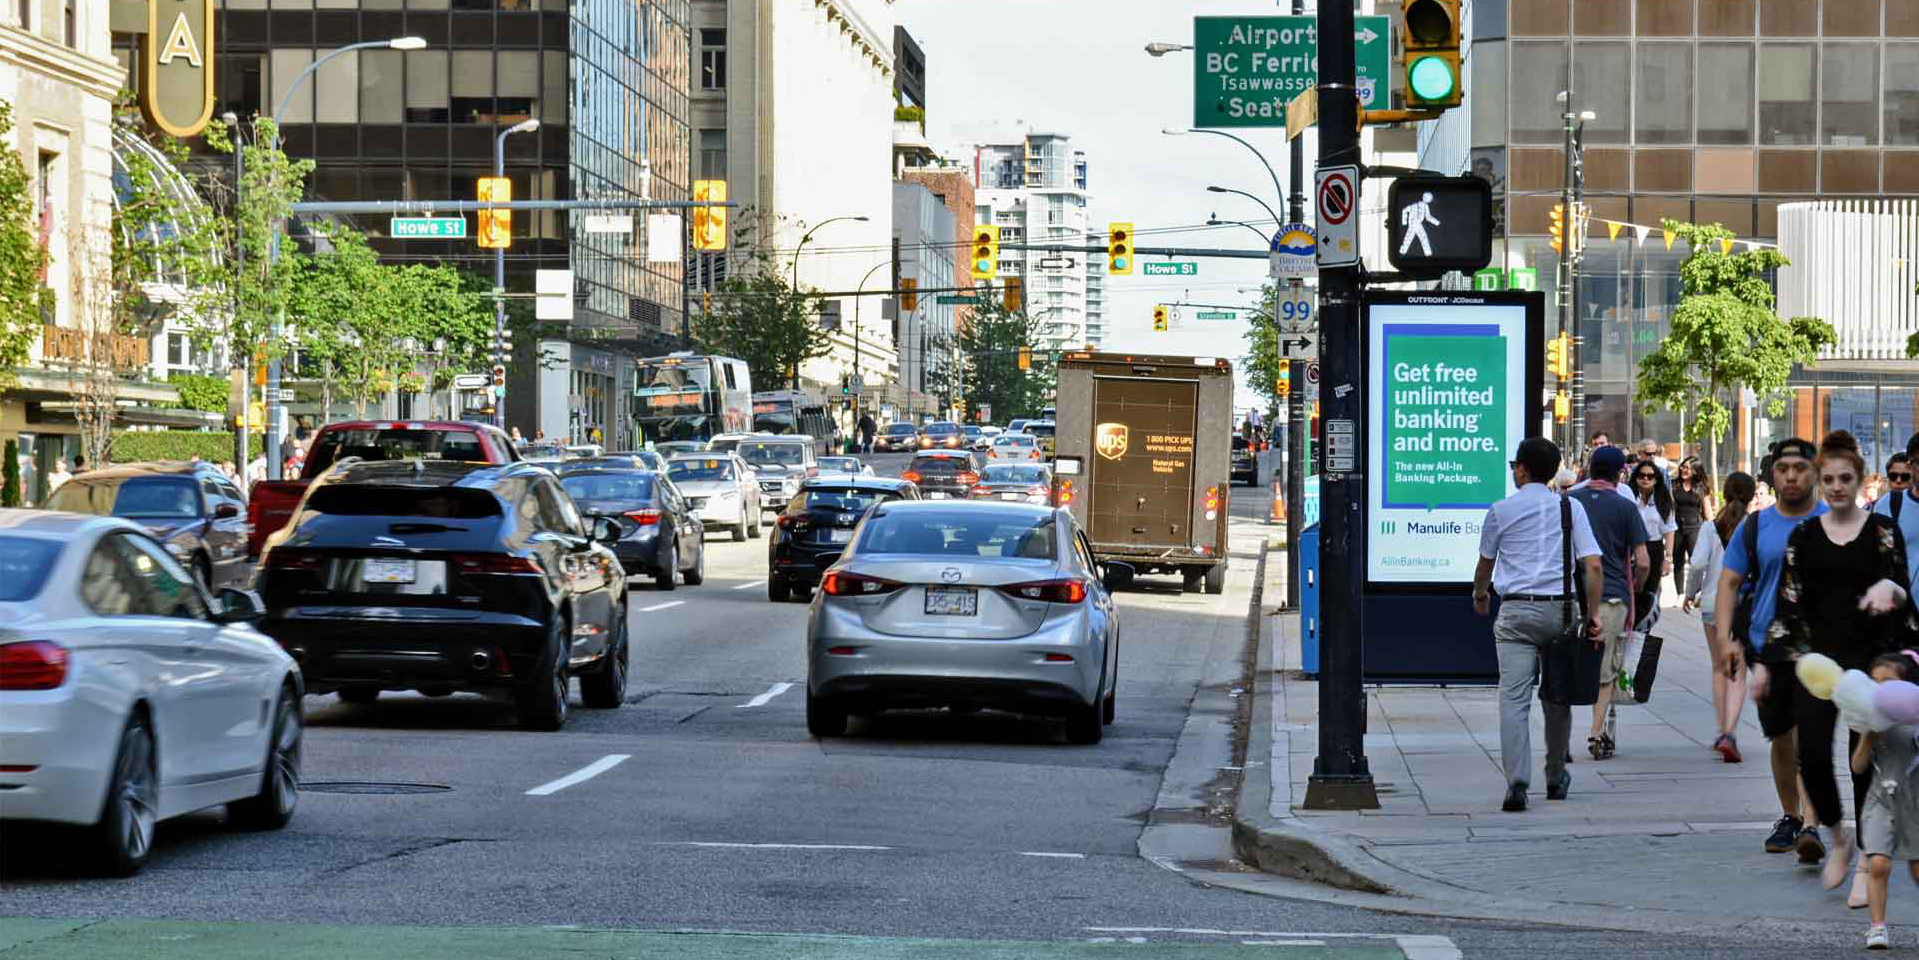

In [10]:
from PIL import ImageOps

old_size = image.size  # old_size is in (width, height) format
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio: # '<': cropping, '>': padding
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

# Cropping the original image to the desired aspect ratio
delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)
cropped_image

In [11]:
# Resize the cropped image to the desired model size
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1

In [12]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_path)

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = cropped_image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

In [13]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
      'road',
      'sidewalk',
      'building',
      'wall',
      'fence',
      'pole',
      'traffic light',
      'traffic sign',
      'vegetation',
      'terrain',
      'sky',
      'person',
      'rider',
      'car',
      'truck',
      'bus',
      'train',
      'motorcycle',
      'bicycle',
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

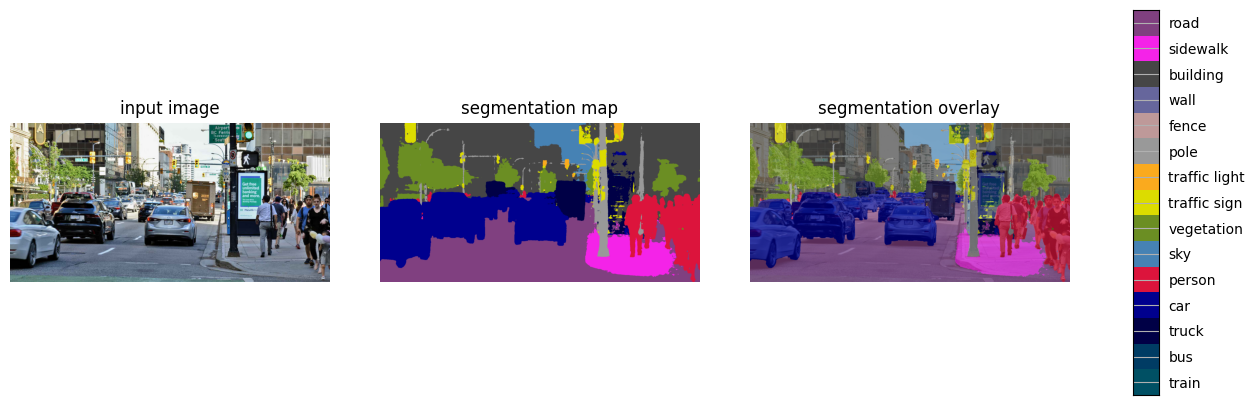

In [14]:
vis_segmentation(cropped_image, seg_map)